# Dask with Rapids Multi GPU Demo [WIP]

<img src="./nb_images/rapids_and_dask.png" alt="Drawing" style="width: 600px;"/>

This Demo will show how to use Dask + Rapids to scale jobs to multiple GPU's and multiple machines using AC922 servers!

### Demo Setup

* start scheduler
* start a single worker via CLI

### Helper functions

Execute the functions below, they are needed for follow-on parts of the lab.  Note the **pgdf** function is a convenience function to display the GPU dataframe in a nice format for jupyter notebook.

In [1]:
# Imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
import timeit

from datetime import datetime
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob
import os
import sys
sys.path.append('../utils/') 

#dask
import dask
from dask import dataframe as dd

# Rapids
import cudf
from cudf.dataframe import DataFrame as RapidsDataFrame
# Dask -CUDF
import dask_cudf

np.random.seed(12)

In [2]:
# [print gpu dataframe] helper function to print GPU dataframes 
def pgdf(gdf) :
    display(gdf.to_pandas())

In [3]:
def time_command(cmd,repeat=1) :
    avg_runtime = timeit.timeit(cmd, number=repeat)
    return float(avg_runtime / repeat)

In [4]:
# Dictionary to store results ..
# example "describe" : {"gpu" : []}
# TODO : make display results look better ..
class COMPARE() :
        ## Abstract Custom Implementations
    def __init__(self) :
        #nprint("Loading Data.  Overriding __init__ from dfutils")
        self.tests = []
        self.gpu_results = {}
        self.cpu_results = {}
        self.df_shape = (0,0)
        self.df_memory_gb = 0 

    def add_result(self, test_name, gpu_result, runtime) :
        if test_name not in self.tests :
            self.tests.append(test_name)
            self.gpu_results[test_name] = []
            self.cpu_results[test_name] = []
        
        if(gpu_result == "gpu") :
            self.gpu_results[test_name].append(runtime)
        else :
            self.cpu_results[test_name].append(runtime)
            
    def display_results(self) :
        print("Dataframe size : {} {} GB".format(self.df_shape, self.df_memory_gb))
        print("{:<20} {:<20} {:<20} {:<20}".format("test", "CPU(s)", "GPU(s)", "GPU Speedup"))
        for i in self.tests :
            cpu_mean = sum(self.cpu_results[i]) / (len(self.cpu_results[i])+0.00001)
            gpu_mean = sum(self.gpu_results[i]) / (len(self.gpu_results[i])+0.00001)
            su = cpu_mean / (gpu_mean + .00001)
            print("{:<20} {:<20.4f} {:<20.4f} {:<20.2f}".format(i, cpu_mean, gpu_mean, su ))

run_times = COMPARE()


# Load Data

In [5]:
# import data
filename = "../dataprep_common/loan_project_df.parquet.gzip"

# Expand data to highlight performance difference
# 3 ~ 1GB dataset
# 4 ~ 2GB dataset 
# ... etc
# 7 - 16GB
DATA_DOUBLE_FACTOR=7

# Pandas dataframe
loan_pdf = pd.read_parquet(filename)#  , names=ts_cols,dtype=ts_dtypes,skiprows=1)

# Rapids Dataframe
loan_rdf = cudf.read_parquet(filename)#  , names=ts_cols,dtype=ts_dtypes,skiprows=1)

In [6]:
# Scale up data to 10 million rows 
for i in range(DATA_DOUBLE_FACTOR) :
    loan_pdf = pd.concat([loan_pdf,loan_pdf],axis=0)
    loan_pdf = loan_pdf.reset_index().drop("index",axis=1)
    #loan_rdf = cudf.concat([loan_rdf,loan_rdf],axis=0)
    #loan_rdf = loan_rdf.reset_index().drop("index",axis=1)
    #pgdf(loan_rdf.head())
    #display(loan_pdf.head())


In [7]:
loan_dadf = dd.from_pandas(loan_pdf,npartitions=4)


In [8]:
# [not working]
#loan_dcdf = dask_cudf.from_dask_dataframe(loan_dadf)

## Start up Dask Workers and scheduler

In [9]:
# conda activate powerai-1.6.1
# dask-scheduler --port 8000
# -->
# distributed.scheduler - INFO - -----------------------------------------------
# distributed.scheduler - INFO - Local Directory:    /tmp/scheduler-ry6vcxoy
# distributed.scheduler - INFO - -----------------------------------------------
# distributed.scheduler - INFO - Clear task state
# /gpfs/gpfs_gl4_16mb/s4s004/vanstee/anaconda3/envs/powerai-1.6.1/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning:
# Port 8787 is already in use.
# Perhaps you already have a cluster running?
# Hosting the diagnostics dashboard on a random port instead.
#   warnings.warn("\n" + msg)
# distributed.dashboard.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: pip install jupyter-server-proxy
# distributed.scheduler - INFO -   Scheduler at:  tcp://129.40.42.114:8786
# distributed.scheduler - INFO -   dashboard at:                    :35599
# 
# 
# --->
# CUDA_VISIBLE_DEVICES=2 dask-worker localhost:8000 --nprocs 1 --nthreads 1
# CUDA_VISIBLE_DEVICES=3 dask-worker localhost:8000 --nprocs 1 --nthreads 1
# 

## Connect to client

In [10]:


#### Portions of this were borrowed and adapted from the
#### cuDF cheatsheet, existing cuDF documentation,
#### and 10 Minutes to Pandas.

In [11]:
#from dask_cuda import LocalCUDACluster
from dask.distributed import Client

#cluster = LocalCUDACluster()  # runs on eight local GPUs
client = Client('p10a114.pbm.ihost.com:8000')

client

Client Scheduler: tcp://p10a114.pbm.ihost.com:8000 Dashboard: http://p10a114.pbm.ihost.com:8787/status,Cluster Workers: 1 Cores: 1 Memory: 3.40 GB


## Dask CPU Example

In [12]:
import dask.array as da
x = da.random.random((10000,10000,10), chunks=(1000,1000,5))
y = da.random.random((10000,10000,10), chunks=(1000,1000,5))
z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1,2))

z.compute()

array([157116.18136746, 157286.34795778, 157168.68446877, ...,
       156910.45805581, 157193.85348709, 157132.67168894])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.321709 to fit


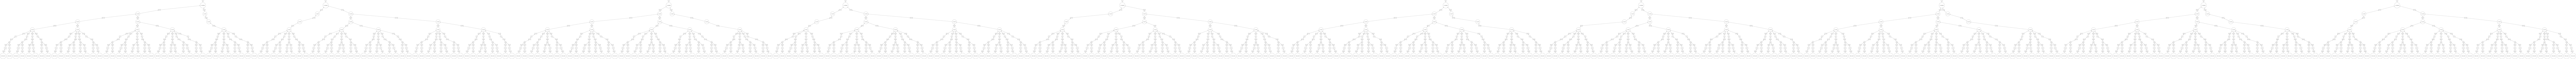

In [13]:
z.visualize()

In [ ]:
# import data
#aaa = "../rawdata/example.csv"

#gdf = dask_cudf.read_csv(aaa)  # wrap around many CSV files
#print(gdf.dtypes)
#gdf.head().to_pandas()
#gdf['loan_amnt'].sum()


In [ ]:
# ~100s runtime ... fix that pls
a = np.random.rand(10000,10000)
df_np = cudf.DataFrame()
df_np = df_np.from_records(a)


## Dask-CUDF  Example

In [14]:
loan_ddf = dask_cudf.from_cudf(loan_rdf, npartitions=8).persist()

In [ ]:
loan_ddf

In [15]:
dir(loan_ddf)
#loan_ddf[["loan_amnt","annual_inc"]].describe()
#loan_ddf.sort_values(by='fico_range_high')
grade_stats_ddf = loan_ddf.groupby('grade').agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"], "dti": ["count","mean"]})

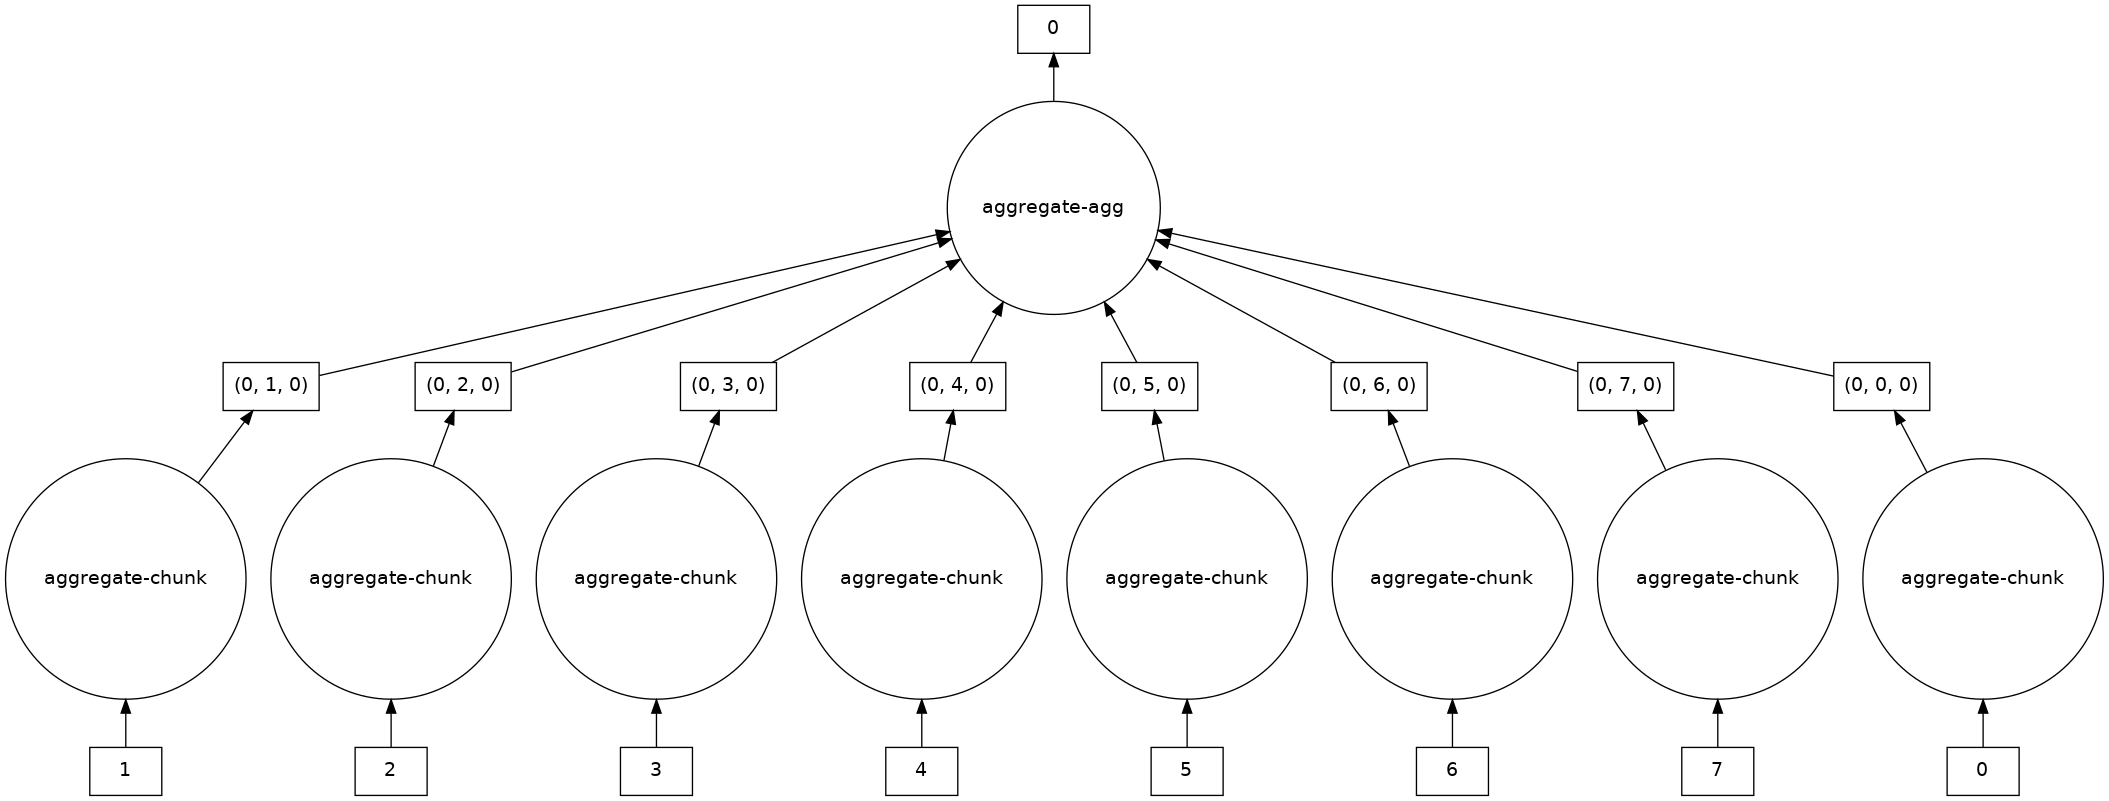

In [16]:
grade_stats_ddf.visualize()

In [20]:
#(ddf[0].sum() + ddf[1].std()).compute()
for i in range(20) :
    grade_stats_ddf.compute().to_pandas()

## xgboost with Rapids [WIP]

In [ ]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import dask.array as da
import numpy as np
import xgboost as xgb
#import GPUtil
import time


# Define the function to be executed on each worker
def train(X, y, available_devices):
    dtrain = xgb.dask.create_worker_dmatrix(X, y)
    local_device = available_devices[xgb.rabit.get_rank()]
    # Specify the GPU algorithm and device for this worker
    params = {"tree_method": "gpu_hist", "gpu_id": local_device}
    print("Worker {} starting training on {} rows".format(xgb.rabit.get_rank(), dtrain.num_row()))
    start = time.time()
    xgb.train(params, dtrain, num_boost_round=500)
    end = time.time()
    print("Worker {} finished training in {:0.2f}s".format(xgb.rabit.get_rank(), end - start))


def main():
    max_devices = 16
    # Check which devices we have locally
    # available_devices = GPUtil.getAvailable(limit=max_devices)
    available_devices = [0,1]
    # Use one worker per device
    cluster = LocalCluster(n_workers=len(available_devices), threads_per_worker=4)
    client = Client(cluster)

    # Set up a relatively large regression problem
    n = 100
    m = 10000000
    partition_size = 100000
    X = da.random.random((m, n), partition_size)
    y = da.random.random(m, partition_size)

    xgb.dask.run(client, train, X, y, available_devices)

main()

## SnapML + Rapids [WIP]

In [ ]:
### SnapML

X = loan_norm_rdfloan_rdf2.to_pandas()
y = loan_rdf['default'].to_pandas()

from pai4sk.linear_model import Ridge as LRSNAP
clf = LRSNAP(alpha=1.0)
clf.fit(X, y) # doctest: +NORMALIZE_WHITESPACE


#Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#      normalize=False, random_state=None, solver='auto', tol=0.001)

# Summary

In [ ]:
#from cudf.core import DataFrame, Series



In [ ]:
print(df[["cats","dogs"]])
print(df.describe())

In [ ]:
print(uvals,labels)

## Lessons Learned

lessons learned ... data MUST be clean prior to descibe functions.  Errors encountered 
- duplicate index caused error (this was due to concatenating dataframes)
- NaN causes KeyError messages.  Columns must be clean !
- Pandas takes care of these automatically ....

In [ ]:
# NaN report
def nan_report(df) :
    for c in df.columns :
        print("{} {}".format(c, df[c].null_count))

nan_report(loan_rdf)

In [ ]:
### SnapML

X = loan_norm_rdfloan_rdf2.to_pandas()
y = loan_rdf['default'].to_pandas()

from pai4sk.linear_model import Ridge as LRSNAP
clf = LRSNAP(alpha=1.0)
clf.fit(X, y) # doctest: +NORMALIZE_WHITESPACE


#Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#      normalize=False, random_state=None, solver='auto', tol=0.001)